# Model Character level

In [3]:
import csv
from coremltools import converters
from datetime import datetime
from IPython.display import SVG
from keras import backend as K
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense, Input, LSTM
from keras.models import Model
from keras.optimizers import RMSprop
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import numpy as np
import os
import sys

In [4]:
# hyper parameters
activations = 128
batch_size = 50
epochs = 10
learning_rate = 0.01
training_ratio = 0.3

In [5]:
# output
output_dir = 'data/'
charset_file = '{}charset.csv'.format(output_dir)
dataset_file = '{}dataset.csv'.format(output_dir)

In [6]:
# to use GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# verify that a gpu is listed
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Functions

In [7]:
def deprocessPrediction(ix_to_char, prediction):
    index = np.argmax(prediction)
    char = ix_to_char[index]
    
    return char

In [8]:
def generateCharacterConverters(chars):
    char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
    ix_to_char = { i:ch for i,ch in enumerate(sorted(chars)) }
    
    return char_to_ix, ix_to_char

In [9]:
def generateXYDatasets(char_to_ix, dataset, n_examples, n_charset, max_char_n):
    # create training input
    x_dataset = np.zeros((n_examples, max_char_n-1, n_charset), dtype='float32')
    
    # create training input
    y_dataset = np.zeros((n_examples, n_charset), dtype='float32')
    
    # fill input training set with word sequences, where words are one-hot encoded
    for li, line in enumerate(dataset):
        for ci, char in enumerate(line[:-1]):
            index = char_to_ix[char]
            x_dataset[li][ci][index] = 1
            
    # create training output
    for li, line in enumerate(dataset):
        char = line[-1]
        index = char_to_ix[char]
        y_dataset[li][index] = 1
        
    return x_dataset, y_dataset

In [10]:
def preprocessExample(char_to_ix, example, n_chars_set):
    chars = list(example)
    n_sample_chars = len(chars)

    preprocessed_example = np.zeros((1, n_sample_chars, n_chars_set), dtype='float32')

    for ci, char in enumerate(chars):
        index = char_to_ix[char]
        preprocessed_example[0][ci][index] = 1

    return preprocessed_example

In [11]:
def sample_predictions(preds, temperature=0.5):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return probas

## Load Data

In [12]:
with open(charset_file, 'r') as csv_file:
    reader = csv.reader(csv_file, delimiter=",")
    charset = []
    for row in reader:
        charset.append(row[0])

In [13]:
with open(dataset_file, 'r') as csv_file:
    reader = csv.reader(csv_file, delimiter=",")
    dataset = []
    for row in reader:
        dataset.append(row)

## Generate Datasets

In [14]:
# create dictionarys
char_to_ix, ix_to_char = generateCharacterConverters(charset)
n_charset = len(charset)

print("Number of characters: {}".format(n_charset))
print("ix_to_char: {}".format(ix_to_char))
print("char_to_ix: {}".format(char_to_ix))

Number of characters: 60
ix_to_char: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: ':', 17: ';', 18: '<', 19: '=', 20: '>', 21: '?', 22: '@', 23: '[', 24: '\\', 25: ']', 26: '^', 27: '_', 28: '`', 29: 'a', 30: 'b', 31: 'c', 32: 'd', 33: 'e', 34: 'f', 35: 'g', 36: 'h', 37: 'i', 38: 'j', 39: 'k', 40: 'l', 41: 'm', 42: 'n', 43: 'o', 44: 'p', 45: 'q', 46: 'r', 47: 's', 48: 't', 49: 'u', 50: 'v', 51: 'w', 52: 'x', 53: 'x', 54: 'y', 55: 'z', 56: '{', 57: '|', 58: '}', 59: '~'}
char_to_ix: {'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, ':': 16, ';': 17, '<': 18, '=': 19, '>': 20, '?': 21, '@': 22, '[': 23, '\\': 24, ']': 25, '^': 26, '_': 27, '`': 28, 'a': 29, 'b': 30, 'c': 31, 'd': 32, 'e': 33, 'f': 34, 'g': 35, 'h': 36, 'i': 37, 'j': 38, 'k': 39, 'l': 40, 'm': 41, 'n': 42, 'o': 43, 'p': 44, 'q': 45, 'r': 46, 's

In [15]:
# create training input and output
n_examples = len(dataset)
max_char_n = len(dataset[0])
x_dataset, y_dataset = generateXYDatasets(char_to_ix, dataset, n_examples, n_charset, max_char_n)
print("Number of examples: {}".format(n_examples))
print("max characters: {}".format(max_char_n))

Number of examples: 100000
max characters: 20


## Validate Dataset

In [16]:
x_example = x_dataset[2] 

x_example_string = []
for woh in x_example:
    char = deprocessPrediction(ix_to_char, woh)
    x_example_string.append(char)
x_example_string_formatted = "".join(x_example_string)

print("x_example shape: {}".format(x_example.shape))
print("x_example one-hot: {}".format(x_example))
print("x_example: {}".format(x_example_string_formatted))

x_example shape: (19, 60)
x_example one-hot: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
x_example: en you (when you)
g


In [17]:
y_example = y_dataset[2]

char = deprocessPrediction(ix_to_char, y_example)

print("y_example shape: {}".format(y_example.shape))
print("y_example one-hot: {}".format(y_example))
print("y_example: {}".format(char))

y_example shape: (60,)
y_example one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_example: e


## Model

In [18]:
model_input = Input(shape=(None, n_charset))
x = LSTM(activations)(model_input)
x = Dense(n_charset, activation='softmax')(x)

In [19]:
model = Model(inputs=model_input, outputs=x)

optimizer = RMSprop(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Plot model

In [20]:
# generate logging variables
variant = '{}ex-{}a-{}b-{}c'.format(n_examples, activations, batch_size, max_char_n)
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
diagram_dir = 'diagram/{}-{}'.format(variant, timestamp)
log_dir = 'logs/{}-{}'.format(variant, timestamp)
mlmodel_dir = 'model/{}-{}.mlmodel'.format(variant, timestamp)
model_dir = 'model/{}-{}.hdf5'.format(variant, timestamp)

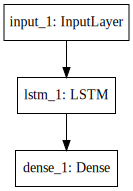

In [21]:
# draw a model diagram and save it to disk
plot_model(model, to_file=diagram_dir)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 60)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               96768     
_________________________________________________________________
dense_1 (Dense)              (None, 60)                7740      
Total params: 104,508
Trainable params: 104,508
Non-trainable params: 0
_________________________________________________________________


In [23]:
## Train the model

In [24]:
# set up callbacks
early = EarlyStopping(monitor='val_acc',
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')

In [25]:
model.fit(x_dataset, 
          y_dataset, 
          batch_size=batch_size, 
          epochs=epochs, 
          shuffle=True,
          validation_split=training_ratio,
          callbacks=[early, TensorBoard(log_dir=log_dir)])

Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 57s 816us/step - loss: 2.1063 - acc: 0.3837 - val_loss: 1.8163 - val_acc: 0.4573
Epoch 2/10
70000/70000 [==============================] - 57s 807us/step - loss: 1.7312 - acc: 0.4810 - val_loss: 1.6907 - val_acc: 0.4918
Epoch 3/10
70000/70000 [==============================] - 57s 811us/step - loss: 1.6149 - acc: 0.5108 - val_loss: 1.6701 - val_acc: 0.5014
Epoch 4/10
70000/70000 [==============================] - 57s 811us/step - loss: 1.5421 - acc: 0.5309 - val_loss: 1.6350 - val_acc: 0.5121
Epoch 5/10
70000/70000 [==============================] - 57s 817us/step - loss: 1.4926 - acc: 0.5473 - val_loss: 1.6315 - val_acc: 0.5171
Epoch 6/10
70000/70000 [==============================] - 58s 822us/step - loss: 1.4569 - acc: 0.5544 - val_loss: 1.6227 - val_acc: 0.5166
Epoch 7/10
70000/70000 [==============================] - 57s 821us/step - loss: 1.4261 - acc: 0.5648 - val_loss: 1.

## Export Model

In [26]:
model.save(model_dir)

In [27]:
coreml_model = converters.keras.conver(model)
coreml_model.save(mlmodel_dir)

AttributeError: module 'coremltools.converters.keras' has no attribute 'conver'